In [1]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix , accuracy_score
import cv2
from keras import backend as K
import numpy as np
from numpy import argmax

color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['.config', 'sample_data']


In [2]:
import sys
print(sys.executable)

/usr/bin/python3


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [5]:
print(os.listdir("./drive"))

['.shortcut-targets-by-id', 'Shared drives', 'My Drive', '.Trash']


In [0]:
# Define path to the data directory
data_dir = Path('./drive/My Drive/Pattern Recognition/Dataset/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [7]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,drive/My Drive/Pattern Recognition/Dataset/che...,1
1,drive/My Drive/Pattern Recognition/Dataset/che...,1
2,drive/My Drive/Pattern Recognition/Dataset/che...,1
3,drive/My Drive/Pattern Recognition/Dataset/che...,1
4,drive/My Drive/Pattern Recognition/Dataset/che...,1


1    3875
0    1357
Name: label, dtype: int64


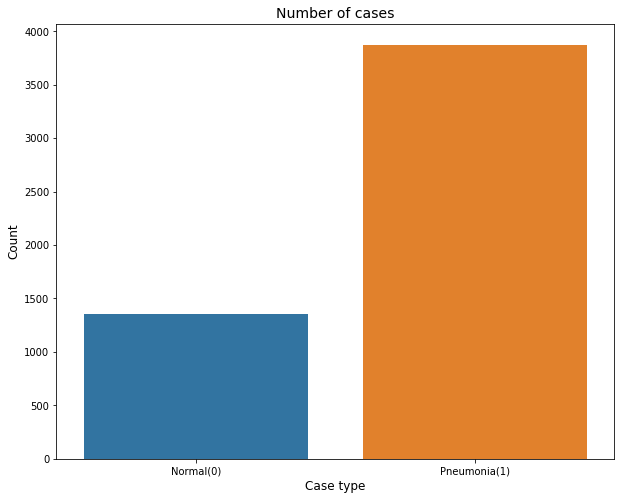

In [8]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [21]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [0]
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [1]
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 1)


In [22]:
print(valid_labels[0].shape)

(1,)


In [0]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [0]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,1), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
              
           # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = [label]
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = [label]
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = [label]
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [0]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
def build_model():
    base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(224,224,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(100, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [14]:
model =  build_model()
# model.load_weights('weight1.h5')
model.summary()











87916544/87910968 [==============================] - 8s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
_________________

In [15]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [56]:
batch_size = 32
nb_epochs = 10

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 163 and 16


In [57]:
# Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                              class_weight={0:1.0, 1:0.4})

Epoch 1/10
  5/163 [..............................] - ETA: 34:42 - loss: 0.3526 - acc: 0.6875

KeyboardInterrupt: ignored

In [0]:
# summarize history for accuracy
plt.figure(figsize=(12,6),)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy',color = 'white')
plt.ylabel('accuracy',color = 'white')
plt.xlabel('epoch',color = 'white')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss',color = 'white')
plt.ylabel('loss',color = 'white')
plt.xlabel('epoch',color = 'white')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

In [0]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

In [0]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)


In [0]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=14)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=14)
plt.show()

In [0]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

In [0]:
from sklearn.metrics import roc_curve,auc

predss = model.predict(test_data)

fpr, tpr, threshold = roc_curve(orig_test_labels,  predss)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,'b',label='AUC = %0.2f' % roc_auc)
plt.legend(loc= 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()



Ensemble


In [0]:
from keras.models import load_model
from numpy import array
from numpy import argmax
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

In [0]:
# create directory for models
# os.makedirs('models')

model.save_weights(filepath='model/weight1.h5')

In [0]:
 
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# sum across ensemble members
	summed = numpy.sum(yhats, axis=0)
	# argmax across classes
	result = sigmoid(summed, axis=1)
	return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	print(len(subset))
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)

In [0]:
# list of model
members = []
# evaluate different numbers of ensembles
scores = list()
for i in range(1, n_members+1):
	score = evaluate_n_members(members, i, testX, testy)
	print('> %.3f' % score)
	scores.append(score)
x_axis = [i for i in range(1, n_members+1)]
pyplot.plot(x_axis, scores)
pyplot.show()